# Variational Autoencoder

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

## Load MNIST Data
![MNIST from Wikipedia](./media/MnistExamples.png)

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

path = "./data"
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
train_loader

In [4]:
x = iter(train_loader)
images = next(x) # list of images and labels

In [6]:
images[0].shape

torch.Size([100, 1, 28, 28])

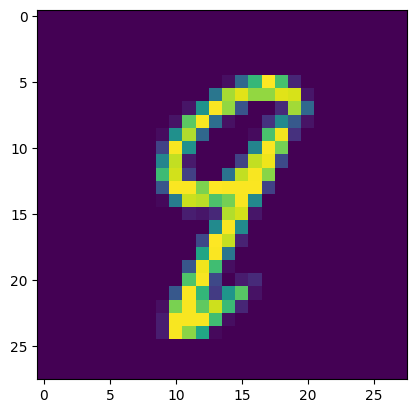

In [7]:
# show the first image in first batch
plt.imshow(images[0][0,0,:,:])
plt.show()

![VAE](./media/VAE.png)

In [8]:
device = torch.device("cpu")
if torch.backends.mps.is_available(): 
    device = torch.device("mps")
print(device)

mps


In [9]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )        

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def decode(self, x):
        return self.decoder(x)

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decoder(z)
        return x_hat, mean, logvar

In [10]:
def loss_function(x_hat, x, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1  + logvar - mean.pow(2) - logvar.exp())
    return reproduction_loss + KLD

In [11]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
from time import time
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        start = time()
        epoch_loss = 0
        for batch_idx, (x,_) in enumerate(train_loader):
            x_dim = 784
            x = x.view(batch_size, x_dim).to(device)
            
            optimizer.zero_grad()

            x_hat, mean, logvar = model(x)
            loss = loss_function(x_hat, x, mean, logvar)

            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        print("Epoch: ",epoch, "Epoch Loss:", epoch_loss/((batch_idx+1)*batch_size),"in", time()-start, "seconds")
            

In [13]:
train(model, optimizer, epochs=10, device=device)

Epoch:  0 Epoch Loss: 230.62917340494792 in 10.048668146133423 seconds
Epoch:  1 Epoch Loss: 179.50298025716145 in 5.225509881973267 seconds
Epoch:  2 Epoch Loss: 171.14412275390626 in 5.24210786819458 seconds
Epoch:  3 Epoch Loss: 166.7331778157552 in 5.0346291065216064 seconds
Epoch:  4 Epoch Loss: 163.24519663085937 in 5.044435262680054 seconds
Epoch:  5 Epoch Loss: 161.1147579264323 in 5.0268330574035645 seconds
Epoch:  6 Epoch Loss: 159.58008274739583 in 5.042057037353516 seconds
Epoch:  7 Epoch Loss: 158.2598766438802 in 5.083578109741211 seconds
Epoch:  8 Epoch Loss: 157.00188522135417 in 5.0467400550842285 seconds
Epoch:  9 Epoch Loss: 155.8451519856771 in 5.027647018432617 seconds


## Now use the trained Model to Generate new Images from Random Data

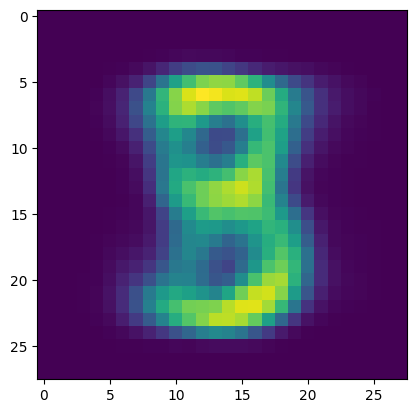

In [15]:
z = torch.tensor([[0, 0]], dtype=torch.float).to(device)
x = model.decode(z)
x = x.reshape(28,28)
x = x.cpu().detach().numpy()
plt.imshow(x)
plt.show()

In [16]:
horizontal, vertical = 11, 11
means = list(np.linspace(start=-1, stop=1, num=horizontal))
vars = list(np.linspace(start=0, stop=1, num=vertical))

fig, axs = plt.subplots(horizontal, vertical, figsize=(horizontal*10, vertical*10))

for h, mean in enumerate(means):
    for v, var in enumerate(vars):
        z = torch.tensor([[mean, var]], dtype=torch.float).to(device)
        x = model.decode(z)
        x = x.reshape(28,28)
        x = x.cpu().detach().numpy()
        axs[v,h].imshow(x)
        axs[v,h].set_title(f"{round(mean,2)} - {round(var,2)}",fontsize='large')

plt.savefig("./test.png")
plt.show()

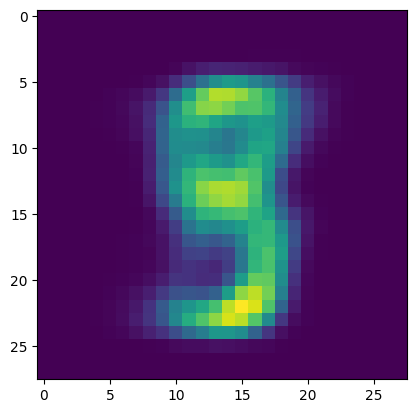

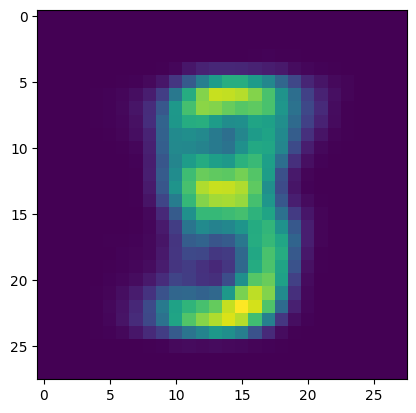

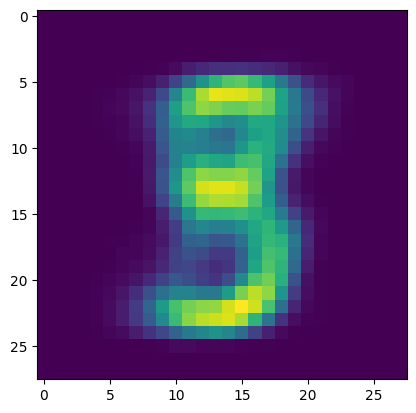

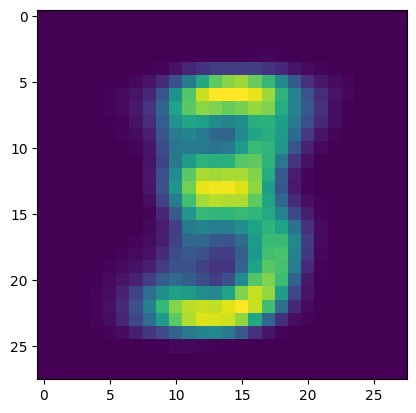

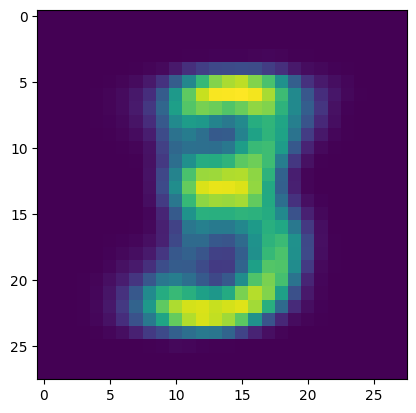

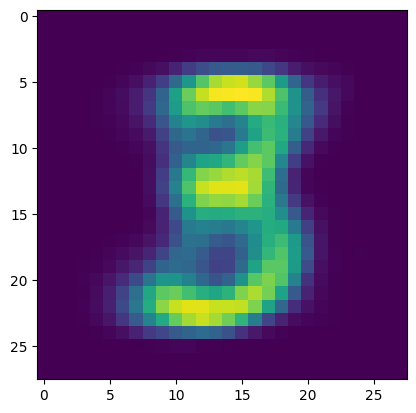

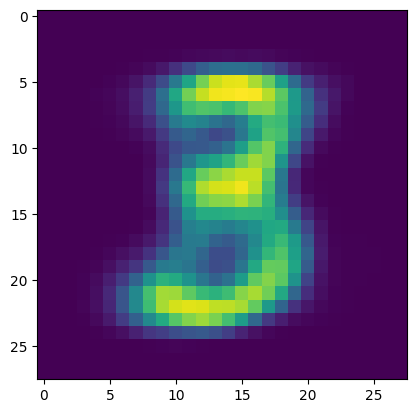

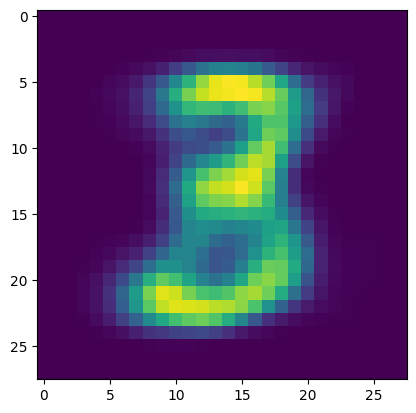

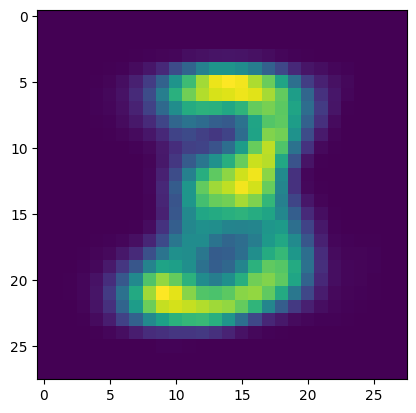

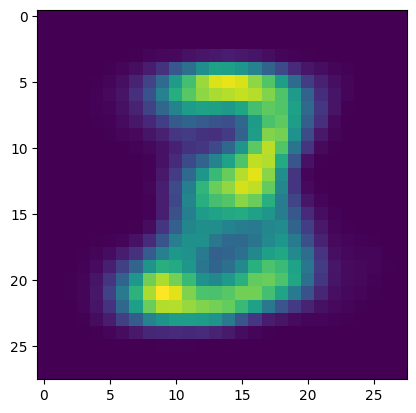

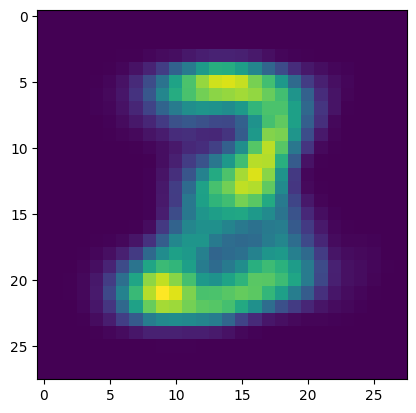

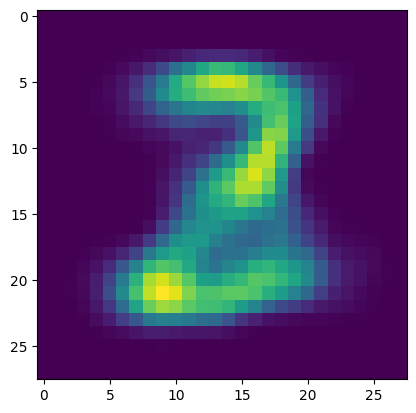

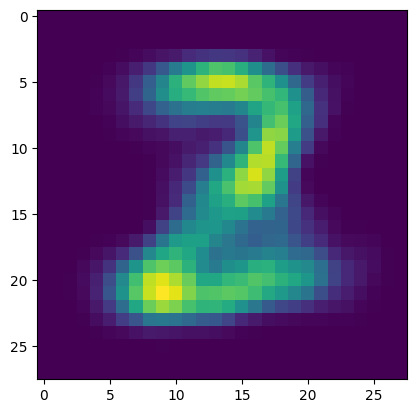

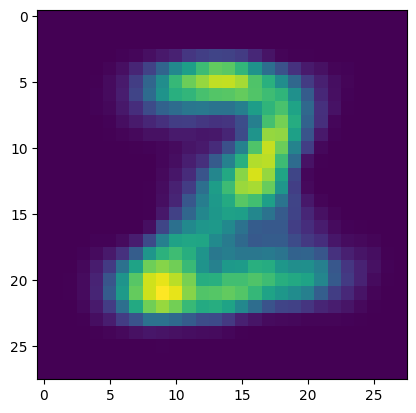

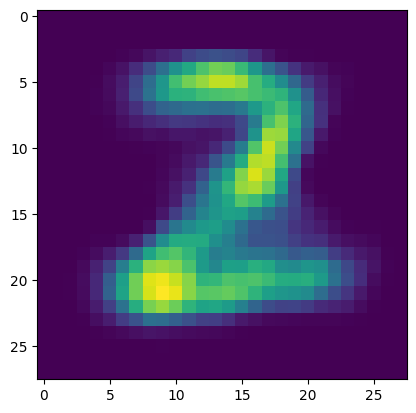

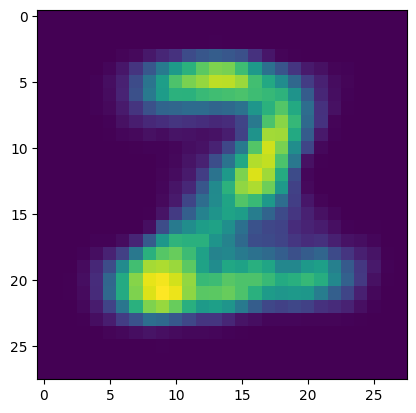

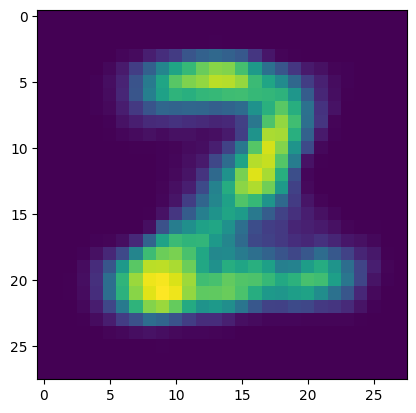

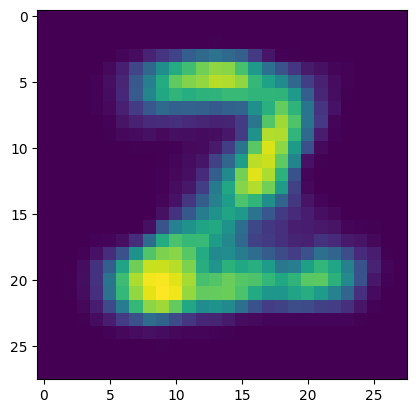

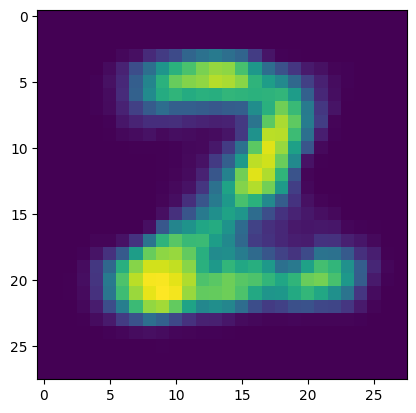

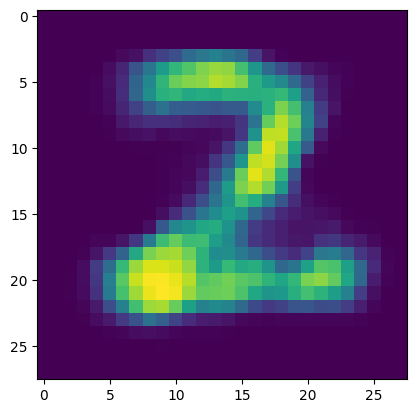

In [20]:
for var in range(20):
    z = torch.tensor([[0.5, var/10]], dtype=torch.float).to(device)
    x = model.decode(z)
    x = x.reshape(28,28)
    x = x.cpu().detach().numpy()
    plt.imshow(x)
    plt.show()